Final Project

CSCI S-89a Deep Learning, Summer  2019

Harvard University Extension School

Prof. Zoran B. Djordjević

Name: Tianyuan Cai

# Generation of Captions from Images

## Motivation

Image captioning has a large variety of applications. By understanding common objects in an image, and transforming them into text information, we can compress large photographic infomation into more compact data formats. This ability can be applied in a wide range of fields such as voice over technologies, product recommendation, etc. 

## Preparing Environment

I start by installing packages that do not commonly come with Anaconda. This particular program uses tensorflow-gpu on a Titan Xp GPU. The `tqdm` package might be needed when loading encoded images on a computer with limited memory. 

Download necessary packages and dependencies.

In [90]:
# !pip install pillow numpy scikit-image keras Cython pycocotools nltk

# import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')

Import packages.

In [191]:
import os
import pickle
from time import time
import json
import re
import random

from pycocotools.coco import COCO
import numpy as np
import sklearn
import keras
from PIL import Image
import tensorflow as tf

import skimage.io as io
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pylab
pylab.rcParams['figure.figsize'] = (4, 6)
from keras.applications.inception_v3 import preprocess_input

import nltk
from nltk.stem import WordNetLemmatizer

In [70]:
# Test if running on GPU
keras.backend.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

## Load Data

The data source used for this analysis is called COCO, common objects in context. See [Coco API](https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb) for package usage. 

COCO dataset provides a set of images that identifies common objects in context. The data include both images and captions that describes the objects and their context.

We start by extracting image and caption (annotation) data from COCO website. 

In [71]:
data_dir = "/home/tcai/Documents/nlp/final_project"
data_type = "train2017"
zipfile_name = '%s.zip'%(data_type)

# # Annotation file
# annotation_zip = tf.keras.utils.get_file('captions.zip',
#                                          cache_subdir=os.path.abspath('.'),
#                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip',
#                                          extract = True)
# annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_%s.json'%(data_type)
annotation_file = data_dir + '/annotations/captions_%s.json'%(data_type)

# # Data Set (using training as the entire dataset)
# image_zip = tf.keras.utils.get_file(zipfile_name,
#                                     cache_subdir=os.path.abspath('.'),
#                                     origin = 'http://images.cocodataset.org/zips/%s'%(zipfile_name),
#                                     extract = True)
image_dir = data_dir+'/%s/'%(data_type)

Coco provides images that are categorized into a variety of categories. The categories listed below can be used to index images in the data set.

In [72]:
# Initialize COCO api for instance annotations
coco_caps=COCO(annotation_file)

# Obtain categories
annFile='{}/annotations/instances_{}.json'.format(data_dir, data_type)
coco=COCO(annFile)

cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('\nCOCO Categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO Supercategories: \n{}'.format(' '.join(nms)))

loading annotations into memory...
Done (t=0.64s)
creating index...
index created!
loading annotations into memory...
Done (t=12.11s)
creating index...
index created!

COCO Categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO Supercategories: 
electronic vehicle furniture indoor animal outdoor sports accessory food person appliance kitchen


The index of the chosen image is 106484.

The corresponding captions are:
A man walking a dalmatian on a red leash.
The man has a red leash on his Dalmatian dog.
a man walks a dog with a leech 
A guy is walking his dalmatian down the road. 
A man walking a dalmatian on leash in front of a firetruck.


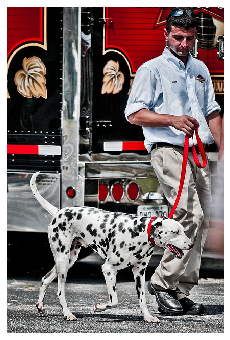

In [192]:
# Show sample data set by choosing categories
temp_cat = ['dog','person', 'ball']

catIds = coco.getCatIds(catNms=temp_cat)
imgIds = coco.getImgIds(catIds=catIds)

if len(imgIds) > 0:
    imgIds = coco.getImgIds(imgIds = imgIds[-1]) # Pick the last image
    print("The index of the chosen image is %s.\n"%(str(imgIds[0])))
else:
    print("No matched images found.")

# load and display captions
annIds = coco_caps.getAnnIds(imgIds)
anns = coco_caps.loadAnns(annIds)
print("The corresponding captions are:")
coco_caps.showAnns(anns)

# Show image
img = coco.loadImgs(imgIds)[0]
I = io.imread('%s/%s/%s'%(data_dir,data_type,img['file_name']))
plt.imshow(I); plt.axis('off'); plt.show()

## Train-test Split

Captions, images paths, and encoded image features are needed in order to effectively implemented the training. Rather than using `train_test_split` function, I choose to shuffle the data and subset to the desired number of train and test samples.

In [74]:
total_examples = 100000
train_examples = int(0.8 * total_examples)

# Subset training and testing images
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

all_img_path_vector = {}
all_img_name_vector = list(set([x['image_id'] for x in annotations['annotations']]))
print("Choosing %s training images and %s testing from a total of %s images"%(train_examples, total_examples - train_examples, len(all_img_name_vector)))

for img_id in all_img_name_vector:
    img = coco.loadImgs(img_id)[0]
    image_file_path = '%s/%s/%s'%(data_dir,data_type,img['file_name'])
    all_img_path_vector[img_id] = image_file_path
    
all_img_name_vector = sklearn.utils.shuffle(all_img_name_vector, random_state = 0)
all_img_name_vector = all_img_name_vector[:total_examples] # subset

train_img_name_vector = all_img_name_vector[:train_examples] # train
test_img_name_vector = all_img_name_vector[train_examples:] # test

Choosing 80000 training images and 20000 testing from a total of 118287 images


## Extract Image Features using InceptionV3 and ImageNet

I use a pre-trained model, Inception V3 model, to encode images such that we can extract the spacial content of the images. I took out the final fully-connected layer in order to pass the features along to the image captioning model. When encoding, note that hash table is used to ensure I am encoding distinct images. This is because one image has multiple captions associated with it. 

### Obtain the image encoder

In [75]:
# https://keras.io/applications/#inceptionv3
# feature_model = keras.applications.inception_v3.InceptionV3(weights='imagenet')
image_model = keras.applications.InceptionV3(weights='imagenet')
feature_model = keras.models.Model(image_model.input, image_model.layers[-2].output)

Define encoding function that:
* Transform the image into consistent sizes
* Convert the images to array
* Expand dimensions
* Preprocess the input
* Reshape images

In [129]:
# Encoding function for feature extraction
def encode(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = keras.applications.inception_v3.preprocess_input(img_array)
    fea_vec = feature_model.predict(img_array)
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return(fea_vec)

### Testing Inception V3 on COCO data set

In [130]:
# Testing
len(encode('/home/tcai/Documents/nlp/final_project/train2017/000000262145.jpg'))

2048

In [131]:
# Testing image model
import keras.applications.imagenet_utils

def inceptionv3_predict(image_path, image_model):
#     image_path = '/home/tcai/Documents/nlp/final_project/train2017/000000262145.jpg'
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = keras.applications.inception_v3.preprocess_input(img_array)
    preds = image_model.predict(img_array)
    P = keras.applications.imagenet_utils.decode_predictions(preds)
    
    # Show prediction result
    for (i, (imagenetID, label, prob)) in enumerate(P[0]):
        print("{}. {}: {:.2f}%".format(i + 1, label, prob * 100))
    
    # Show image
    I = io.imread(image_path)
    plt.imshow(I); plt.axis('off'); plt.show()

1. Polaroid_camera: 47.31%
2. reflex_camera: 5.75%
3. hand-held_computer: 1.86%
4. oscilloscope: 1.72%
5. switch: 1.35%


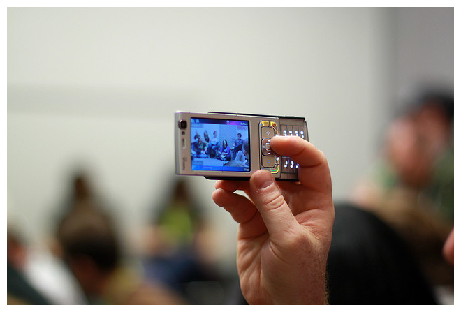

In [132]:
random_img_id = random.choice(all_img_name_vector)
random_img_path = all_img_path_vector[random_img_id]
inceptionv3_predict(random_img_path, image_model)

### Encode images and store the resulting features

In [133]:
# # Encode all the train images
# start = time()
# train_features = {}
# for img_id in all_img_name_vector:
#     train_features[img_id] = encode(all_img_path_vector[img_id])

# print("Time taken in seconds =", time() - start)

# # Pickle the features
# with open(data_dir + "/encoded_train_images.pkl", "wb") as encoded_pickle:
#     pickle.dump(train_features, encoded_pickle)

In [134]:
train_features = pickle.load(open(data_dir + "/encoded_train_images.pkl", "rb"))
print('%d photos are encoded. These include both training and testing image set' % len(train_features))

100000 photos are encoded. These include both training and testing image set


For each captions in the training and testing data set, I append images back onto the captions so that all captions and features are included.

In [135]:
# Train images
captions = []
images = []
images_features = []

for img_id in train_img_name_vector:
    img_path = all_img_path_vector[img_id]
    img_feature = train_features[img_id]
    img_captions = coco_caps.loadAnns(coco_caps.getAnnIds(img_id))
    
    for caption in [x['caption'] for x in img_captions]:
        captions.append('start_sentence ' + caption + ' end_sentence')
        images.append(img_path)
        images_features.append(img_feature)

captions, images, images_features = sklearn.utils.shuffle(captions, images, images_features, random_state = 0)

In [136]:
# Test images
test_captions = []
test_images = []
test_images_features = []

for img_id in test_img_name_vector:
    img_path = all_img_path_vector[img_id]
    img_feature = train_features[img_id]
    img_captions = coco_caps.loadAnns(coco_caps.getAnnIds(img_id))
    
    for caption in [x['caption'] for x in img_captions]:
        test_captions.append('start_sentence ' + caption + ' end_sentence')
        test_images.append(img_path)
        test_images_features.append(img_feature)

test_captions, test_images, test_images_features = sklearn.utils.shuffle(test_captions, 
                                                                         test_images, 
                                                                         test_images_features, 
                                                                         random_state = 0)

In [137]:
print('I take a total of %s distinct images with %s captions for training,'%(len(list(set(images))), 
                                                                                len(captions)))
print('and reserve %s distinct images with %s captions for testing'%(len(list(set(test_images))),
                                                                     len(test_captions)))

I take a total of 80000 distinct images with 400204 captions for training,
and reserve 20000 distinct images with 100057 captions for testing


As an example: 

The caption for the following image is: 
start_sentence A green bench sitting up against a brick wall. end_sentence


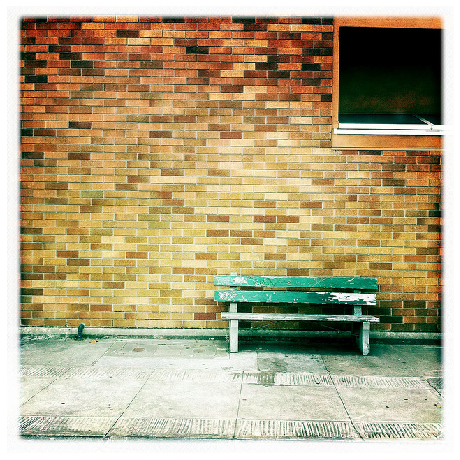

The corresponding encoded feature dimension is (2048,)


In [138]:
test_idx = random.choice(range(len(captions)))

print("As an example: \n\nThe caption for the following image is: \n%s"%(captions[test_idx]))

I = io.imread(images[test_idx])
plt.imshow(I); plt.axis('off'); plt.show()

print("The corresponding encoded feature dimension is " + str(images_features[test_idx].shape))

## Tokenize Captions

### Understanding Word Distribution in the Caption Data

In [139]:
# New - understanding vocab distribution
word_list = []
for caption in captions:
    seq = caption.split(" ")
    word_list += seq

word_list = [word for word in word_list if 
             word and 
             word not in nltk.corpus.stopwords.words('english') and
             "_" not in word]

In [140]:
lemmatizer = WordNetLemmatizer()
word_list = [lemmatizer.lemmatize(w) for w in word_list]

# Calculate frequency distribution
word_list_dist = nltk.FreqDist(word_list)

# Output top 25 words
limit = 25
word_dict = dict()
for word, frequency in word_list_dist.most_common(limit):
    print(u'{};{}'.format(word, frequency))
    word_dict[word] = frequency

A;233432
man;46384
sitting;35517
standing;28306
next;24959
woman;24795
white;23639
people;23611
Two;19051
holding;18768
The;17165
person;15989
large;15574
table;14161
top;13926
group;13921
street;13489
near;13285
two;13136
small;12684
front;12666
dog;12526
tennis;12403
riding;12309
train;12206
black;11936
cat;11767
plate;10986
red;10927
young;10660
sign;10309
An;10111
playing;9666
walking;9531
baseball;9407
room;9124
it.;9091
blue;8897
bus;8576
green;8312
parked;8252
bathroom;8240
boy;7946
player;7845
looking;7719
pizza;7676
giraffe;7596
horse;7427
kitchen;7374
couple;7330


In [141]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [142]:
number_of_words = 6000
# Choose the top 3000 words from the vocabulary
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words= number_of_words, oov_token="<unk>", 
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^`{|}~ ')
tokenizer.fit_on_texts(captions)
train_seqs = tokenizer.texts_to_sequences(captions)

In [143]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [144]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(captions)

52


## Word Embeddings

In [226]:
# Calculates sentence and vocab lengths
# max_length = calc_max_length(train_seqs)
max_length = 30   # This can be changed later
vocab_size = len(tokenizer.index_word)
print("Original xax sentence length is %s; I set it to %s."%(calc_max_length(train_seqs), max_length))
print("The vocabulary size is: %s"%(vocab_size))

Original xax sentence length is 52; I set it to 30.
The vocabulary size is: 23636


In [146]:
embedding_dim = 300
embeddings_index = {}

with open(data_dir + '/glove.6B.%sd.txt'%(embedding_dim), encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [147]:
# Get dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in (tokenizer.word_index).items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [148]:
embedding_matrix.shape

(23636, 300)

# Model

In [149]:
inputs1 = tf.keras.Input(shape=(2048,))
fe1 = tf.keras.layers.Dropout(0.5)(inputs1)
fe2 = tf.keras.layers.Dense(256, activation='relu')(fe1)
inputs2 = tf.keras.Input(shape=(max_length,))
se1 = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = tf.keras.layers.Dropout(0.5)(se1)
se3 = tf.keras.layers.LSTM(256)(se2)
decoder1 = tf.keras.layers.Add()([fe2, se3])
decoder2 = tf.keras.layers.Dense(256, activation='relu')(decoder1)
outputs = tf.keras.layers.Dense(vocab_size, activation='softmax')(decoder2)
model = tf.keras.models.Model(inputs=[inputs1, inputs2], outputs=outputs)

W0728 10:49:10.057519 140226069796672 deprecation.py:506] From /home/tcai/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0728 10:49:10.215717 140226069796672 deprecation.py:323] From /home/tcai/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:3794: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [151]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [152]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [224]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 300)      7090800     input_5[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_4[0][0]                    
____________________________________________________________________________________________

# Train Model

In [158]:
def create_sequences(tokenizer, max_length, caption, image_feature):
    Ximages, XSeq, y = list(), list(),list()
    vocab_size = len(tokenizer.word_index)
    seq = tokenizer.texts_to_sequences([caption])[0]
    # split one sequence into multiple X,y pairs
    for i in range(1, len(seq)):
        # select
        in_seq, out_seq = seq[:i], seq[i]
        # pad input sequence
        in_seq = tf.keras.preprocessing.sequence.pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
        # encode output sequence
        out_seq = tf.keras.utils.to_categorical([out_seq], num_classes=vocab_size)[0]

        image_feature = np.squeeze(image_feature)
        Ximages.append(image_feature)
        XSeq.append(in_seq)
        y.append(out_seq)
    Ximages, XSeq, y = np.array(Ximages), np.array(XSeq), np.array(y)
    return [Ximages, XSeq, y]

In [159]:
def data_generator(tokenizer, max_length, captions, images_features, batch_size):
    # loop for ever over images
    n = 0
    while True:
        for i in range(len(captions)):
            in_img_vector = []
            in_seq_vector = []
            out_word_vector = []
            # load an image from file
            image_feature = images_features[i]
            # create word sequences
            caption = captions[i]
            in_img, in_seq, out_word = create_sequences(tokenizer, max_length, caption, image_feature)
            in_img_vector.append(in_img)
            in_seq_vector.append(in_seq)
            out_word_vector.append(out_word)
            n += 1
            if n == batch_size:
                n = 0
                yield [in_img, in_seq], out_word

In [213]:
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'start_sentence'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = tf.keras.preprocessing.sequence.pad_sequences([sequence], maxlen=max_length, padding='post')
        
        photo = photo.reshape(2048,1).T
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word[yhat]
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end_sentence':
            break

    in_text = re.sub(r'(start|end)_sentence', '', in_text).strip()
    return in_text

In [162]:
# Store defautl weights
epoch_idx = 0
model.save_weights('model/model.h5')

In [171]:
# After trying out different batch sizes, 1000 seems to provide reasonable results
training_record = {}
epochs = 20
number_pics_per_batch = 1000

In [ ]:
# Reset model with default weights before training
model.load_weights('model/model.h5')

steps = len(captions)//number_pics_per_batch
training_record[number_pics_per_batch] = []
epoch_idx = 0

while epoch_idx < epochs:
    generator = data_generator(tokenizer, max_length, captions, images_features, number_pics_per_batch)
    model.fit_generator(generator, steps_per_epoch=steps, verbose=1)
    model.save_weights('model/final_model_epoch' + str(epoch_idx) + "_bs" + str(number_pics_per_batch) +'.h5')
    epoch_idx += 1

    distinct_desc = []
    temp_desc = ''
    for j in range(20):
        img_desc = generate_desc(model, tokenizer, images_features[j], max_length)
        distinct_desc.append(img_desc)
        temp_desc += '' + img_desc

    training_record[number_pics_per_batch].append(distinct_desc)
    print("Model %s generated %s distinct captions with %s distinct words."%(epoch_idx, 
                                                                             len(list(set(distinct_desc))),
                                                                             len(list(set(temp_desc.split(' '))))))

Training Performance with a batch size of 100 and 19 epochs

Predicted Caption: a man is riding a bike down the street 
Actual Caption:  a small girl snuggles with a stuffed animals  


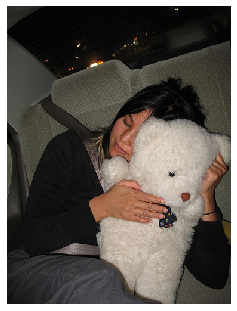

Predicted Caption: a person is snowboarding down a snow covered car 
Actual Caption:  A birthday cake with candles sits on a table. 


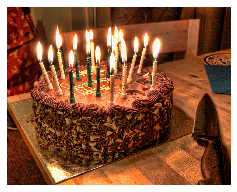

Predicted Caption: a man is eating a doughnut with his laptops 
Actual Caption:  Multiple pillows sit together on a white quilt. 


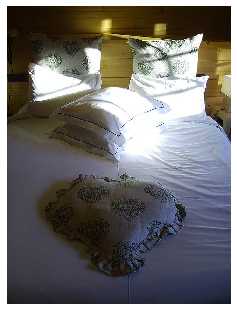

Predicted Caption: a baseball player getting ready to swing a field 
Actual Caption:  A baseball batter poises his bat while others look on. 


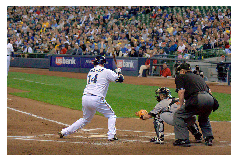

Predicted Caption: a close up of a plate of food cart 
Actual Caption:  A young man holding a foot long hot dog covered in pickles. 


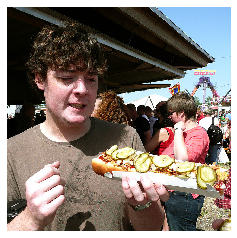

In [223]:
# Train images
print("Training Performance with a batch size of %s and %s epochs.\n"%(number_pics_per_batch, epochs - 1))

model.load_weights('model/final_model_epoch%s_bs%s.h5'%(epochs - 1, number_pics_per_batch))
for j in np.random.choice(range(len(test_captions)), 5):
    # Compare captions
    img_desc = generate_desc(model, tokenizer, test_images_features[j], max_length)
    actual_caption = test_captions[j]
    actual_caption = re.sub(r'(start|end)_sentence', '', actual_caption)

    print("Predicted Caption: %s \nActual Caption: %s"%(img_desc, actual_caption))
    # Show image
    I = io.imread(test_images[j])
    plt.imshow(I); plt.axis('off'); plt.show()

### Compare model performances for Different Batch Sizes

#### Train Model

In [ ]:
training_record = {}
epochs = 20

In [ ]:
# Trying otu different batch sizes
for number_pics_per_batch in [50, 100, 500, 1000]:
    model.load_weights('model/model.h5')
    steps = len(captions)//number_pics_per_batch
    print(number_pics_per_batch)
    training_record[number_pics_per_batch] = []
    epoch_idx = 0
    while epoch_idx < epochs:
        generator = data_generator(tokenizer, max_length, captions, images_features, number_pics_per_batch)
        model.fit_generator(generator, steps_per_epoch=steps, verbose=1)
        model.save_weights('model/model_epoch' + str(epoch_idx) + "_bs" + str(number_pics_per_batch) +'.h5')
        epoch_idx += 1

        distinct_desc = []
        temp_desc = ''
        for j in range(20):
            img_desc = generate_desc(model, tokenizer, images_features[j], max_length)
            distinct_desc.append(img_desc)
            temp_desc += '' + img_desc
        
        training_record[number_pics_per_batch].append(distinct_desc)
        print("Model %s generated %s distinct captions with %s distinct words."%(epoch_idx, 
                                                                                 len(list(set(distinct_desc))),
                                                                                 len(list(set(temp_desc.split(' '))))))

#### Model Performance on training data

Choose a random image

In [185]:
np.random.seed(0)
rand_train_image = np.random.choice(range(len(captions)))

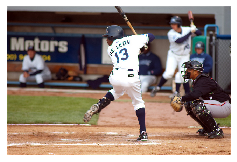

The actual caption is:
A baseball player at bat with his leg raised holding the bat. 

The predicted captions are:
Batch size = 50: a man in a baseball game playing tennis
Batch size = 100: a man on a tennis court with a racket
Batch size = 500: a person lost their skateboard when trying to do a trick in the air
Batch size = 1000: an image of a batter holding a baseball bat at home plate


In [214]:
I = io.imread(images[rand_train_image])
plt.imshow(I); plt.axis('off'); plt.show()

actual_caption = captions[rand_train_image]
actual_caption = re.sub(r'(start|end)_sentence', '', actual_caption).strip()
print("The actual caption is:\n%s \n\nThe predicted captions are:"%(actual_caption))
    
for bs in [50, 100, 500, 1000]:
    model.load_weights('model/model_epoch%s_bs%s.h5'%(epochs - 1, bs))
    # Compare captions
    img_desc = generate_desc(model, tokenizer, images_features[rand_train_image], max_length)

    actual_caption = re.sub(r'(start|end)_sentence', '', actual_caption)
    print("Batch size = %s: %s"%(bs, img_desc))

#### Model Performance on test data

In [187]:
rand_test_image = np.random.choice(range(len(test_captions)))

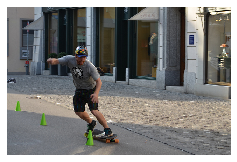

The actual caption is:
A man riding a skateboard through neon cones. 

The predicted captions are:
Batch size = 50: a man is standing in front of a building
Batch size = 100: a man is sitting on the ground near a boat
Batch size = 500: a surfer with <unk> on his face stands on the beach
Batch size = 1000: a girl sitting on a skateboard in front of sand


In [218]:
I = io.imread(images[rand_test_image])
plt.imshow(I); plt.axis('off'); plt.show()

actual_caption = captions[rand_test_image]
actual_caption = re.sub(r'(start|end)_sentence', '', actual_caption).strip()
print("The actual caption is:\n%s \n\nThe predicted captions are:"%(actual_caption))
    
for bs in [50, 100, 500, 1000]:
    model.load_weights('model/model_epoch%s_bs%s.h5'%(epochs - 1, bs))
    # Compare captions
    img_desc = generate_desc(model, tokenizer, images_features[rand_test_image], max_length)

    actual_caption = re.sub(r'(start|end)_sentence', '', actual_caption)
    print("Batch size = %s: %s"%(bs, img_desc))